## Import libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
import sys
import os
cwd = os.getcwd()
sys.path.append(cwd + "/../")

In [3]:
# Streamlit Calculator imports
from streamlit_sample_size_calculator import (
    sample_size_comparing_two_means,
    sample_size_comparing_two_proportions,
    sample_size_estimating_mean,
    sample_size_estimating_proportion,
)
# statsmodels imports
from statsmodels.stats.power import TTestIndPower
from scipy.stats import norm
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
power_analysis = TTestIndPower()

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Parameters

In [3]:
# Parameters for Monte Carlo explicitly set for 250 experiments each, so 500 in total
n_experiments_per_formula = 250

# Z-values clearly defined
confidence_levels = [0.90, 0.95, 0.99]
power_levels = [0.80, 0.85, 0.90, 0.95]
alpha_values = [1 - cl for cl in confidence_levels]

# Explicitly creating randomized combinations of parameters
np.random.seed(42)  # Ensuring reproducibility clearly

## `Streamlit Sample Size Calculator` vs. `statsmodels`
* There is no direct built-in Statsmodels method explicitly designed for pure margin-of-error-based estimation scenarios for a single mean or proportion.

In [6]:
# Container for results
results = []

# 1. Comparing Two Means
for _ in range(n_experiments_per_formula):
    variance = np.random.uniform(50, 500)
    delta = np.random.uniform(0.1, 10)
    alpha = np.random.choice(alpha_values)
    power = np.random.choice(power_levels)

    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)

    user_n = sample_size_comparing_two_means(variance, z_alpha, z_beta, delta)
    effect_size_std = delta / np.sqrt(variance)

    power_analysis = TTestIndPower()
    statsmodels_n = np.ceil(power_analysis.solve_power(
        effect_size=effect_size_std, power=power, alpha=alpha, alternative='two-sided'))
    abs_diff = abs(user_n - statsmodels_n)

    results.append({
        'Formula': 'Two Means (A/B)',
        'Variance': variance,
        'Delta': delta,
        'Alpha': alpha,
        'Power': power,
        'p1': None,
        'p2': None,
        'p': None,
        'Margin_of_Error': None,
        'User_n': user_n,
        'Statsmodels_n': statsmodels_n,
        'Difference': abs_diff,
        'Rel_difference': abs_diff / max(user_n, statsmodels_n) if max(user_n, statsmodels_n) != 0 else np.nan
    })

# 2. Comparing Two Proportions
for _ in range(n_experiments_per_formula):
    p1 = np.random.uniform(0.01, 0.5)
    p2 = min(p1 + np.random.uniform(0.01, 0.3), 0.99)
    alpha = np.random.choice(alpha_values)
    power = np.random.choice(power_levels)

    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)

    user_n = sample_size_comparing_two_proportions(p1, p2, z_alpha, z_beta)

    effect_size = proportion_effectsize(p1, p2)
    power_analysis = NormalIndPower()
    statsmodels_n = np.ceil(power_analysis.solve_power(
        effect_size=effect_size, power=power, alpha=alpha, alternative='two-sided', ratio=1.0))
    abs_diff = abs(user_n - statsmodels_n)

    results.append({
        'Formula': 'Two Proportions (A/B)',
        'Variance': None,
        'Delta': None,
        'Alpha': alpha,
        'Power': power,
        'p1': p1,
        'p2': p2,
        'p': None,
        'Margin_of_Error': None,
        'User_n': user_n,
        'Statsmodels_n': statsmodels_n,
        'Difference': abs_diff,
        'Rel_difference': abs_diff / max(user_n, statsmodels_n) if max(user_n, statsmodels_n) != 0 else np.nan
    })

# # 3. Estimating a Single Mean
# for _ in range(n_experiments_per_formula):
#     variance = np.random.uniform(50, 500)
#     margin_of_error = np.random.uniform(0.1, 10)
#     alpha = np.random.choice(alpha_values)

#     z_alpha = norm.ppf(1 - alpha / 2)

#     user_n = sample_size_estimating_mean(variance, z_alpha, margin_of_error)
#     statsmodels_n = user_n # statsmodels_n doesn't have a direct equivalent for this
#     abs_diff = abs(user_n - statsmodels_n)

#     results.append({
#         'Formula': 'Single Mean',
#         'Variance': variance,
#         'Delta': None,
#         'Alpha': alpha,
#         'Power': None,
#         'p1': None,
#         'p2': None,
#         'p': None,
#         'Margin_of_Error': margin_of_error,
#         'User_n': user_n,
#         'Statsmodels_n': statsmodels_n,
#         'Difference': abs_diff,
#         'Rel_difference': abs_diff / max(user_n, statsmodels_n) if max(user_n, statsmodels_n) != 0 else np.nan
#     })

# # 4. Estimating a Single Proportion
# for _ in range(n_experiments_per_formula):
#     p = np.random.uniform(0.01, 0.5)
#     margin_of_error = np.random.uniform(0.01, 0.1)
#     alpha = np.random.choice(alpha_values)

#     z_alpha = norm.ppf(1 - alpha / 2)

#     user_n = sample_size_estimating_proportion(p, z_alpha, margin_of_error)
#     statsmodels_n = user_n # statsmodels_n doesn't have a direct equivalent for this
#     abs_diff = abs(user_n - statsmodels_n)

#     results.append({
#         'Formula': 'Single Proportion',
#         'Variance': None,
#         'Delta': None,
#         'Alpha': alpha,
#         'Power': None,
#         'p1': None,
#         'p2': None,
#         'p': p,
#         'Margin_of_Error': margin_of_error,
#         'User_n': user_n,
#         'Statsmodels_n': statsmodels_n,
#         'Difference': abs_diff,
#         'Rel_difference': abs_diff / max(user_n, statsmodels_n) if max(user_n, statsmodels_n) != 0 else np.nan
#     })

# Compile results explicitly into a DataFrame
monte_carlo_df = pd.DataFrame(results)

# Explicitly separate the Monte Carlo results into individual DataFrames per formula
two_means_df = monte_carlo_df[monte_carlo_df['Formula'] == 'Two Means (A/B)'].dropna(axis=1)
two_proportions_df = monte_carlo_df[monte_carlo_df['Formula'] == 'Two Proportions (A/B)'].dropna(axis=1)
# single_mean_df = monte_carlo_df[monte_carlo_df['Formula'] == 'Single Mean'].dropna(axis=1)
# single_proportion_df = monte_carlo_df[monte_carlo_df['Formula'] == 'Single Proportion'].dropna(axis=1)

In [7]:
two_means_df

,Formula,Variance,Delta,Alpha,Power,User_n,Statsmodels_n,Difference,Rel_difference
0,Two Means (A/B),85.738716,0.948017,0.10,0.95,2065,2066.0,1.0,0.000484
1,Two Means (A/B),136.340296,3.301378,0.01,0.85,327,329.0,2.0,0.006079
2,Two Means (A/B),209.748338,0.787296,0.10,0.95,7325,7325.0,0.0,0.000000
3,Two Means (A/B),80.425654,8.023529,0.01,0.95,45,47.0,2.0,0.042553
4,Two Means (A/B),293.005362,8.812783,0.05,0.90,80,81.0,1.0,0.012346
...,...,...,...,...,...,...,...,...,...
245,Two Means (A/B),294.140466,8.631251,0.05,0.95,103,104.0,1.0,0.009615
246,Two Means (A/B),151.825599,3.903972,0.01,0.95,355,357.0,2.0,0.005602
247,Two Means (A/B),310.669859,7.617575,0.01,0.95,191,193.0,2.0,0.010363
248,Two Means (A/B),450.343415,0.221866,0.01,0.80,213697,213698.0,1.0,0.000005


In [8]:
two_means_df[two_means_df['Rel_difference'] > 0.03]

,Formula,Variance,Delta,Alpha,Power,User_n,Statsmodels_n,Difference,Rel_difference
3,Two Means (A/B),80.425654,8.023529,0.01,0.95,45,47.0,2.0,0.042553
8,Two Means (A/B),77.064054,5.666738,0.10,0.80,30,31.0,1.0,0.032258
13,Two Means (A/B),59.011860,7.398084,0.10,0.80,14,15.0,1.0,0.066667
22,Two Means (A/B),143.829731,9.312893,0.05,0.85,30,31.0,1.0,0.032258
29,Two Means (A/B),112.639111,8.992790,0.05,0.80,22,23.0,1.0,0.043478
50,Two Means (A/B),158.540656,9.761150,0.05,0.80,27,28.0,1.0,0.035714
55,Two Means (A/B),226.577175,9.566600,0.10,0.80,31,32.0,1.0,0.031250
72,Two Means (A/B),68.878051,9.688039,0.10,0.95,16,17.0,1.0,0.058824
73,Two Means (A/B),181.769917,9.801706,0.05,0.80,30,31.0,1.0,0.032258
117,Two Means (A/B),60.886294,8.333801,0.10,0.85,13,14.0,1.0,0.071429


In [9]:
two_means_df['Rel_difference'].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).to_frame().T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
Rel_difference,250.0,0.00921,0.013226,0.0,0.0,0.0,0.000616,0.004274,0.011494,0.027857,0.040917,0.071429


In [10]:
two_means_df['Difference'].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).to_frame().T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
Difference,250.0,1.088,0.55992,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,3.0


In [11]:
two_means_df.to_csv('data/two_means_monte_carlo-st-v-statsmodels.csv', index=False)

In [12]:
two_proportions_df

,Formula,Alpha,Power,p1,p2,User_n,Statsmodels_n,Difference,Rel_difference
250,Two Proportions (A/B),0.10,0.95,0.091761,0.226615,154,153.0,1.0,0.006494
251,Two Proportions (A/B),0.01,0.80,0.383334,0.667861,67,70.0,3.0,0.042857
252,Two Proportions (A/B),0.01,0.90,0.263447,0.383331,446,450.0,4.0,0.008889
253,Two Proportions (A/B),0.01,0.80,0.199079,0.438677,83,86.0,3.0,0.034884
254,Two Proportions (A/B),0.05,0.95,0.059617,0.315288,55,54.0,1.0,0.018182
...,...,...,...,...,...,...,...,...,...
495,Two Proportions (A/B),0.10,0.90,0.023873,0.094781,186,172.0,14.0,0.075269
496,Two Proportions (A/B),0.10,0.80,0.359350,0.372683,16139,16139.0,0.0,0.000000
497,Two Proportions (A/B),0.10,0.80,0.462773,0.505219,1711,1713.0,2.0,0.001168
498,Two Proportions (A/B),0.05,0.90,0.395396,0.678730,60,64.0,4.0,0.062500


In [27]:
two_proportions_df.head().to_clipboard()

In [13]:
two_proportions_df['Rel_difference'].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).to_frame().T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
Rel_difference,250.0,0.025945,0.031909,0.0,0.000031,0.00065,0.00387,0.016398,0.038105,0.057493,0.079526,0.195122


In [14]:
two_proportions_df['Difference'].describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).to_frame().T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,max
Difference,250.0,3.54,4.697303,0.0,0.45,1.0,2.0,3.0,4.0,5.0,7.1,55.0


In [15]:
two_proportions_df.to_csv('data/two_proportions_monte_carlo-st-v-statsmodels.csv', index=False)

## Visualize it

In [ ]:
def plot_rel_difference_distribution(df, col='Rel_difference', formula_col_name='Formula', scenario='Two Means (A/B)', 
                                     use_median=False):
    df = df.copy()
    df = df[df[formula_col_name] == scenario]
    plt.figure(figsize=(6, 4))

    # Plotting histogram with KDE explicitly
    sns.histplot(df[col], kde=True, color='skyblue', bins=30)

    if use_median:
        # Compute median and interquartile ranges explicitly
        median = df[col].median()
        pct25 = df[col].quantile(0.25)
        pct75 = df[col].quantile(0.75)

        # Add vertical lines explicitly for median and percentiles
        plt.axvline(median, color='red', linestyle='-', linewidth=2, label=f'Median: {median:.4f}')
        plt.axvline(pct25, color='green', linestyle='--', linewidth=1.5, label=f'25th pct: {pct25:.4f}')
        plt.axvline(pct75, color='green', linestyle='--', linewidth=1.5, label=f'75th pct: {pct75:.4f}')
        
        plt.title(f'Distribution of {col} ({scenario}) [Median & IQR]', fontsize=14)
    else:
        # Compute mean and std deviation explicitly
        mean = df[col].mean()
        std = df[col].std()

        # Normal distribution explicitly
        xmin, xmax = df[col].min(), df[col].max()
        x = np.linspace(xmin, xmax, 100)
        p = np.exp(-0.5*((x - mean)/std)**2) / (std * np.sqrt(2 * np.pi))
        plt.plot(x, p * len(df[col]) * (xmax - xmin) / 30, 'r--', linewidth=2, label='Normal Fit')

        # Add vertical lines explicitly for mean and std dev
        plt.axvline(mean, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean:.4f}')
        plt.axvline(mean + std, color='green', linestyle='--', linewidth=1.5, label=f'+1 Std Dev: {mean + std:.4f}')
        plt.axvline(mean - std, color='green', linestyle='--', linewidth=1.5, label=f'-1 Std Dev: {mean - std:.4f}')
        
        plt.title(f'Distribution of {col} ({scenario}) [Mean & Std Dev]', fontsize=14)

    # Common labels and formatting explicitly
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    sns.despine(trim=True, offset=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f"docs/{col}_distribution.png", dpi=300)
    plt.show()

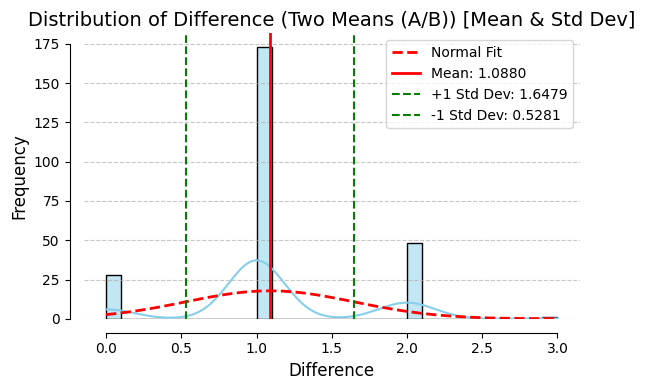

In [56]:
plot_rel_difference_distribution(two_means_df, col='Difference', formula_col_name='Formula', scenario='Two Means (A/B)', use_median=False)

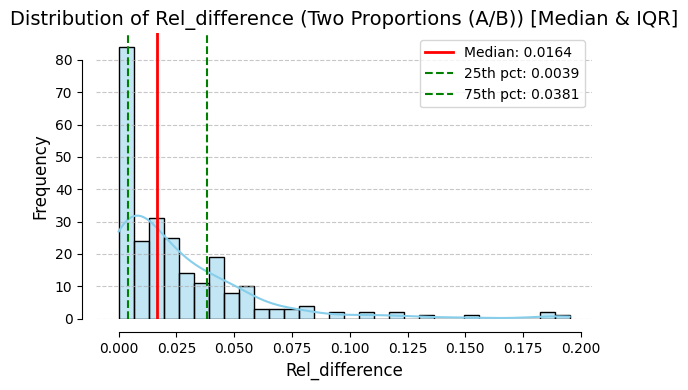

In [57]:
plot_rel_difference_distribution(two_proportions_df, col='Rel_difference', formula_col_name='Formula', scenario='Two Proportions (A/B)', use_median=True)